In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
print(torch.__version__)

2.8.0+cpu


In [3]:
print(torch.cuda.is_available())

False


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 channels (RGB)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32*16*16, 128)  # 64x64 input → after 2 pool layers → 16x16
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=15)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)


In [9]:
# -------------------
# 1. Check current working directory
# -------------------
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\garvi\Desktop\ai_circuit_solver\notebooks


In [18]:
# Parent folder of notebooks
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # go up one level
data_dir = os.path.join(base_dir, 'split_data')

train_dir = os.path.join(data_dir, 'train')
val_dir   = os.path.join(data_dir, 'val')
test_dir  = os.path.join(data_dir, 'test')
print(data_dir)
print("Train folder exists:", os.path.exists(train_dir))
print("Validation folder exists:", os.path.exists(val_dir))
print("Test folder exists:", os.path.exists(test_dir))

c:\Users\garvi\Desktop\ai_circuit_solver\split_data
Train folder exists: True
Validation folder exists: True
Test folder exists: True


In [19]:
# -------------------
# 3. Transformations
# -------------------
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [22]:
# -------------------
# 4. Datasets
# -------------------
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data   = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_data  = datasets.ImageFolder(test_dir, transform=val_test_transform)

In [23]:
# -------------------
# 5. DataLoaders
# -------------------
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=16, shuffle=False)

In [24]:
classes = train_data.classes
print("Classes:", classes)
print("Train samples:", len(train_data))
print("Validation samples:", len(val_data))
print("Test samples:", len(test_data))

Classes: ['Ammeter', 'ac_src', 'battery', 'cap', 'curr_src', 'dc_volt_src_1', 'dc_volt_src_2', 'dep_curr_src', 'dep_volt', 'diode', 'gnd_1', 'gnd_2', 'inductor', 'resistor', 'voltmeter']
Train samples: 2062
Validation samples: 438
Test samples: 452


In [26]:
device = torch.device("cpu")
model = model.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
num_epochs = 5  # start small

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc*100:.2f}%\n")


Epoch 1/5, Loss: 1.9234
Validation Accuracy: 57.99%

Epoch 2/5, Loss: 1.0042
Validation Accuracy: 69.18%

Epoch 3/5, Loss: 0.7134
Validation Accuracy: 67.35%

Epoch 4/5, Loss: 0.5674
Validation Accuracy: 75.34%

Epoch 5/5, Loss: 0.4324
Validation Accuracy: 75.34%



In [29]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct/total*100:.2f}%")


Test Accuracy: 73.45%


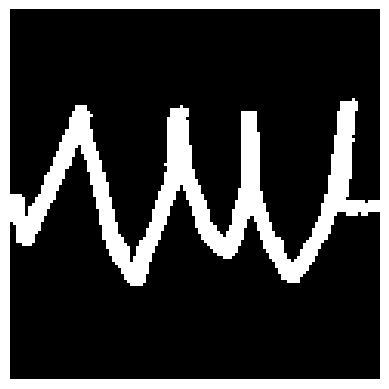

Predicted class: resistor


In [35]:
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

path=os.path.join(test_dir, 'resistor/5.png')
img = Image.open(path).convert('RGB')
plt.imshow(img)
plt.axis('off')
plt.show()
img = transform(img).unsqueeze(0)  # add batch dimension
img = img.to(device)

model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted_class = torch.max(output, 1)


print("Predicted class:", train_data.classes[predicted_class.item()])